In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn import preprocessing
import os
import pickle

from ipywidgets import widgets
%matplotlib inline

In [5]:
# search for csv location

found = []

def find(name,path):
    path = os.getcwd() + path
    file = name

    for root, dir, files in os.walk(path):
        for item in files:
            if file == item:
                return os.path.join(root, file)
        return None
data = ['00', '01', '02', '03', '05', '22', '23', '24', '25']
data = ['00', '01', '02']

for d in data:
    found.append(find('data_' + d + '.csv.gz', '/irc-sphere-sleep-56db93f64661/sphere-sensor-data'))
    found.append(find('data_' + d + '.csv', '/irc-sphere-sleep-56db93f64661/sphere-sensor-data'))
found

[None,
 '/Users/Andrew/Github-repo/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_00.csv',
 None,
 '/Users/Andrew/Github-repo/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_01.csv',
 None,
 '/Users/Andrew/Github-repo/circadian-rhytm/irc-sphere-sleep-56db93f64661/sphere-sensor-data/data_02.csv']

In [6]:
# load file

df = []
for path in found:
    if path is not None:
        if 'gz' in path:
            fileName = path
            df.append(pd.read_csv(fileName, index_col='datetime', compression='gzip'))
        else: 
            fileName = path
            df.append(pd.read_csv(fileName, index_col='datetime'))

/Users/Andrew/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
def getFeatures(df):

    # arm angle calculation using accelerometer data
    df['angle'] = 180 / np.pi * np.arctan(df['wearable-xl1-z'] / np.sqrt(np.square(df['wearable-xl1-x']) + np.square(df['wearable-xl1-z'])))

    # get only interesting columns
    df = df[['angle', 'wearable-mag-xl1']]

    # remove NaN values
    df = df.dropna()
    # convert index to DatetimeIndex
    df.index = pd.DatetimeIndex(df.index)


    # resample data within interval given in resampleInterval ('1S' = 1 second intervals)
    resampleInterval = '1S'
    minimum = df.resample(resampleInterval).min()
    maximum = df.resample(resampleInterval).max()
    mean = df.resample(resampleInterval).mean()
    std = df.resample(resampleInterval).std()
    summ = df.resample(resampleInterval).sum()
    skew = df.resample(resampleInterval).apply(lambda array : stats.skew(array))
    kurtosis = df.resample(resampleInterval).apply(lambda array: stats.kurtosis(array, fisher=True))

    # rename column labels in DataFrame
    minimum.rename(columns={'angle': 'angle min'}, inplace=True)
    minimum.rename(columns={'wearable-mag-xl1': 'magnitude min'}, inplace=True)
    
    maximum.rename(columns={'angle': 'angle max'}, inplace=True)
    maximum.rename(columns={'wearable-mag-xl1': 'magnitude max'}, inplace=True)
    
    mean.rename(columns={'angle': 'angle mean'}, inplace=True)
    mean.rename(columns={'wearable-mag-xl1': 'magnitude mean'}, inplace=True)
    
    std.rename(columns={'angle': 'angle std'}, inplace=True)
    std.rename(columns={'wearable-mag-xl1': 'magnutude std'}, inplace=True)
    
    summ.rename(columns={'angle': 'angle sum'}, inplace=True)
    summ.rename(columns={'wearable-mag-xl1': 'magnitude sum'}, inplace=True)
    
    skew.rename(columns={'angle': 'angle skew'}, inplace=True)
    skew.rename(columns={'wearable-mag-xl1': 'magnitude skew'}, inplace=True)
    
    kurtosis.rename(columns={'angle': 'angle kurtosis'}, inplace=True)
    kurtosis.rename(columns={'wearable-mag-xl1': 'magnitude kurtosis'}, inplace=True)
    
    # collect DataFrames
    features = [minimum, maximum, mean, std, summ, skew, kurtosis]
    features = pd.concat(features, axis=1)

    
    # for some weird reason new nans appear. 
    # need to drop them to have same shape on what to plot
    features = features.dropna()
    std = std.dropna()
    
    return [features, std, df]

In [8]:
# load features from data over all nights
allFeatures = []
allStd = []
for d in df:
    [feature, std, dataf] = getFeatures(d)
    allFeatures.append(feature)
    allStd.append(std)

In [26]:
# normalise the values between a 0 1 range
normalisedFeatures = []
for features in allFeatures:
    features_array = features.values #return a numpy array
    min_max_scalar = preprocessing.MinMaxScaler()
    normalise = min_max_scalar.fit_transform(features_array)
    normalised_features = pd.DataFrame(normalise)

    # rename index and columns
    normalised_features.columns = features.columns
    normalised_features.index = features.index

    features = normalised_features.copy(deep=True)
    normalisedFeatures.append(features)
normalisedFeatures[0]

,angle min,magnitude min,angle max,magnitude max,angle mean,magnitude mean,angle std,magnutude std,angle sum,magnitude sum,angle skew,magnitude skew,angle kurtosis,magnitude kurtosis
datetime,,,,,,,,,,,,,,
2016-05-31 21:59:59,0.107254,0.833935,0.129790,0.015429,0.118587,0.095709,0.032570,0.038432,0.486535,0.220848,0.509983,0.526371,0.000000,0.000000
2016-05-31 22:00:00,0.008414,0.690702,0.999160,0.117978,0.443001,0.177774,0.827292,0.129215,0.470761,0.181027,0.556076,0.683024,0.013020,0.275997
2016-05-31 22:00:01,0.973020,0.915374,0.994278,0.180702,0.984904,0.390116,0.011812,0.135770,0.924564,0.392529,0.454212,0.910402,0.091638,0.676608
2016-05-31 22:00:02,0.946534,0.792327,0.999947,0.066204,0.977460,0.217950,0.034382,0.072668,0.918330,0.221043,0.479027,0.576114,0.042091,0.127718
2016-05-31 22:00:03,0.399263,0.870107,0.999979,0.068951,0.893084,0.316972,0.419196,0.074707,0.847672,0.319674,0.316768,0.497405,0.146247,0.049592
2016-05-31 22:00:04,0.310127,0.461301,0.995748,0.099826,0.763650,0.231458,0.512103,0.157386,0.739280,0.234498,0.426574,0.376420,0.045973,0.289204
2016-05-31 22:00:05,0.963321,0.747657,0.997746,0.109031,0.982788,0.348681,0.017114,0.126335,0.922792,0.351257,0.486260,0.496082,0.103268,0.118966
2016-05-31 22:00:06,0.991209,0.803930,0.999992,0.066711,0.997955,0.306649,0.006262,0.078480,0.935493,0.309392,0.354168,0.419751,0.108019,0.111639
2016-05-31 22:00:07,0.997986,0.916317,0.999997,0.055586,0.999535,0.313595,0.001030,0.029035,0.936817,0.316310,0.317479,0.467962,0.230244,0.157158


In [13]:
data = pd.concat(normalisedFeatures, axis=0)

In [9]:
pickle.dump(normalisedFeatures, open('allFeatures.pkl','wb'))

NameError: name 'normalisedFeatures' is not defined

### Dont load this section! it will overwrite files

In [8]:
# save all data to pkl
data.to_pickle('normalisedDays.pkl')


# Can start from here to load data

In [3]:
# load pickled data
data = pd.read_pickle('normalisedDays.pkl')
normalisedFeatures = pickle.load('allFeatures.pkl')

TypeError: file must have 'read' and 'readline' attributes

In [14]:
# cluster data
label = KMeans(n_clusters=5, random_state=10).fit_predict(data)

<IPython.core.display.Javascript object>


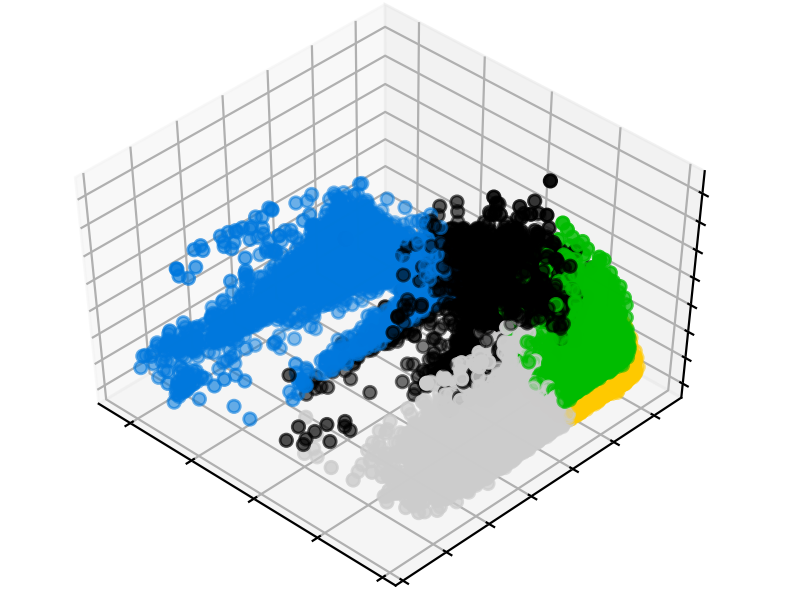

In [15]:
# plot PCA of clusters
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(data)
X = pca.transform(data)

# only needed for non int labels (I think)
# y = np.choose(label, [1, 2, 0]).astype(np.float)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=label, cmap=plt.cm.spectral) # alt. cmap='spring'

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.show()

In [16]:
# scatter of labelled data
plt.scatter(data.index, data['angle std'], c=label)
plt.colorbar()

AttributeError: 'NoneType' object has no attribute 'sqrt'

# Train model and export features

In [17]:
# fit model to data
trainModel = KMeans(n_clusters=5, random_state=10).fit(data)

# this is the model that should be used to predict sleep/not

# TODO: drop doesnt work!

In [29]:
# collect features for the sleep data of each day
sleepFeatures = []
for feature in normalisedFeatures:
    
    # produce new label for each day
    label = trainModel.predict(feature)
    
    # merge clusters
    label[label == 0] = 0
    label[label == 1] = 0
    label[label == 2] = 0
    label[label == 3] = 0
    label[label == 4] = 1
    
    # filter out awake data
    feature2 = feature.copy(deep=True)
    feature2['label'] = label
    sleep = feature2[feature2['label'] != 1]
    
    # statistics calucaltion on given features
    feat = np.concatenate((sleep.mean(), sleep.std(), sleep.skew(), sleep.kurt()), axis=0)
    sleepFeatures.append(feat)
    
    

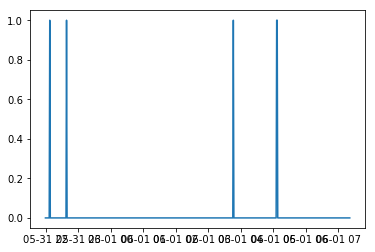

In [50]:
label = trainModel.predict(normalisedFeatures[0])
# merge clusters
label[label == 0] = 0
label[label == 1] = 0
label[label == 2] = 0
label[label == 3] = 0
label[label == 4] = 1

feature2 = normalisedFeatures[0].copy(deep=True)
feature2['label'] = label

feature2 = feature2.resample('1Min').mean()

plt.plot(feature2.index, feature2['label'].round())


In [ ]:
# export sleep features
sleepFeatures=np.asarray(sleepFeatures)
np.save('sleepFeatures.npy', sleepFeatures, allow_pickle=True)

In [47]:
feature2['label'].round()

datetime
2016-05-31 21:59:00    0.0
2016-05-31 22:00:00    0.0
2016-05-31 22:01:00    0.0
2016-05-31 22:02:00    0.0
2016-05-31 22:03:00    0.0
2016-05-31 22:04:00    0.0
2016-05-31 22:05:00    0.0
2016-05-31 22:06:00    0.0
2016-05-31 22:07:00    1.0
2016-05-31 22:08:00    0.0
2016-05-31 22:09:00    0.0
2016-05-31 22:10:00    0.0
2016-05-31 22:11:00    0.0
2016-05-31 22:12:00    0.0
2016-05-31 22:13:00    0.0
2016-05-31 22:14:00    0.0
2016-05-31 22:15:00    0.0
2016-05-31 22:16:00    0.0
2016-05-31 22:17:00    0.0
2016-05-31 22:18:00    0.0
2016-05-31 22:19:00    0.0
2016-05-31 22:20:00    0.0
2016-05-31 22:21:00    0.0
2016-05-31 22:22:00    0.0
2016-05-31 22:23:00    0.0
2016-05-31 22:24:00    0.0
2016-05-31 22:25:00    0.0
2016-05-31 22:26:00    0.0
2016-05-31 22:27:00    0.0
2016-05-31 22:28:00    0.0
                      ... 
2016-06-01 06:52:00    0.0
2016-06-01 06:53:00    0.0
2016-06-01 06:54:00    0.0
2016-06-01 06:55:00    0.0
2016-06-01 06:56:00    0.0
2016-06-01 06:57:00